In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

In [2]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350])
ds = exp.ds

# Spensberger

In [8]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350])
ds = exp.ds
ds = ds.isel(time=slice(100))
u = ds.u.max("lev").load()
v = ds.v.max("lev").load()
u.to_netcdf(f"{DATADIR}/ERA5/tmp/u.nc")
v.to_netcdf(f"{DATADIR}/ERA5/tmp/v.nc")

In [1]:
import netCDF4 as nc
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
from jetstream_hugo.definitions import DATADIR
from jetaxis_detect.jet_detect import jet_detect

no = 10
nf = 5

jet_detect.jetint_thres = 0.124e-8  # K-threshold for instantaneous ERA-Interim, mean winds 925-700 hPa, T84-resolution
jet_detect.searchrad = (
    1.5  # Maximum distance of points along the jet axis in grid point indices
)
jet_detect.minlen = 2.0e6  # Minimum lenght of the jet axes in meters
jet_detect.grid_cyclic_ew = False  # Is grid periodic in x-direction?

tvar, latvar, lonvar = "time", "lat", "lon"
ufile, uvar = f"{DATADIR}/ERA5/tmp/u.nc", "u"
vfile, vvar = f"{DATADIR}/ERA5/tmp/v.nc", "v"

fu = nc.Dataset(ufile)
u = fu.variables[uvar][::].squeeze().data
time = fu.variables[tvar][::].data
lat = fu.variables[latvar][::].data
lon = fu.variables[lonvar][::].data
fu.close()

nz, ny, nx = u.shape

# Load v-data
fv = nc.Dataset(vfile)
v = fv.variables[vvar][::].squeeze().data
fv.close()

dx = np.ones((ny, nx)) * 111.111e3 * np.cos(np.pi / 180.0 * lat)[:, np.newaxis]
dy = np.ones((ny, nx)) * 111.111e3

ja = np.zeros((nz, no, 3))
jaoff = np.zeros((nz, nf))

# Detect jets
ja, jaoff = jet_detect.run_jet_detect(
    no, nf, u, v, dx, dy
)

: 

: 

In [14]:
u.shape

(100, 121, 221)

In [ ]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 30, 20, 80, [150, 200, 250, 300, 350])
thresholds = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/qs_clim.nc")
thresholds = thresholds[20, :].reset_coords("quantile", drop=True)
all_jets, where_are_jets, all_jets_one_array = exp.find_jets(thresholds=thresholds, processes=16, chunksize=200)

# Whole globe tries

In [2]:
from windspharm.xarray import VectorWind

In [3]:
ds = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/tmp/uvfull/195901.nc").rename(level="lev").isel(lon=slice(None, None, 2), lat=slice(None, None, 2))
ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
ds = flatten_by(ds, "s")

In [4]:
w = VectorWind(ds["u"].fillna(0), ds["v"].fillna(0))

In [5]:
ds["u_smo"] = w.truncate(w.u(), truncation=63)
ds["v_smo"] = w.truncate(w.v(), truncation=63)
ds["s_smo"] = np.sqrt(ds["u_smo"] ** 2 + ds["v_smo"] ** 2)

In [6]:
sigmas=range(3, 6)
if "time" in ds.dims:
    filtered = np.zeros_like(ds["s_smo"])
    for t in trange(len(filtered)):
        da = ds["s_smo"][t]
        filtered[t, :, :] = sato(da / da.max(), black_ridges=False, sigmas=sigmas)
        filtered[t] = filtered[t] / filtered[t].max()
ds["criterion"] = ds["s_smo"] * filtered

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:04<00:00, 26.29it/s]


In [14]:
groups, dist_mats = cluster_criterion(ds.isel(time=0), criterion_threshold=10)

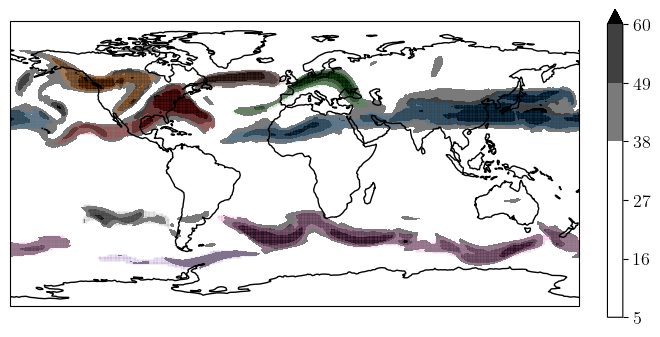

In [15]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds.isel(time=0)["s"]], transparify=3, nlevels=6, cmap="Greys", q=0.96)
ax = clu.axes[0]
for group in groups:
    ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.11)

In [41]:
jets = jets_from_mask(groups, dist_mats)

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_

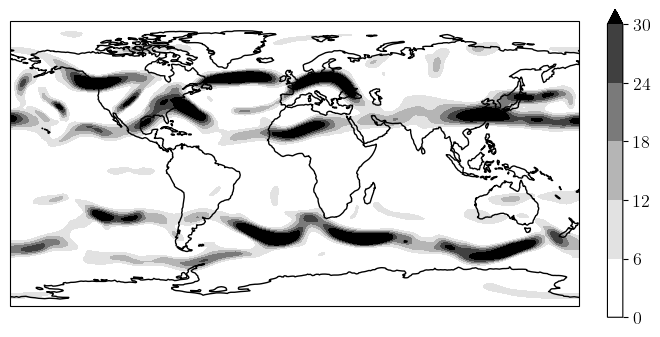

In [46]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds.isel(time=0)["criterion"]], transparify=1, nlevels=6, cmap="Greys", q=0.96)
ax = clu.axes[0]
# for jet in jets:
#     ax.scatter(*jet[["lon", "lat"]].to_numpy().T, lw=2, alpha=0.5)

 19%|█▉        | 12/64 [11:36<50:16, 58.00s/it]


KeyboardInterrupt: 

In [50]:
year, month

(1971, 7)

# SCAFET tests

In [2]:
import scafet.object_properties as obp
import scafet.ridge_detection as rd
import scafet.object_filtering as obf
import scafet.object_tracking as obt

In [3]:
grid_area = xr.open_dataset(f"{DATADIR}/ERA5/grid_info/grid_area_era5.nc")
# .sel(latitude=latslice,longitude=lonslice)
grid_area = grid_area.rename({"longitude": "lon"})
grid_area = grid_area.rename({"latitude": "lat"})
grid_area = grid_area.reindex(lat=list(reversed(grid_area.lat)))
grid_area = grid_area.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))
grid_area = grid_area.assign_coords(lon=((grid_area.lon + 180) % 360) - 180)
grid_area = grid_area.roll(lon=len(grid_area.lon) // 2, roll_coords=True)

land_mask = xr.open_dataset(f"{DATADIR}/ERA5/grid_info/land_sea_mask_era5.nc")
land_mask = land_mask.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))
land_mask = land_mask.assign_coords(lon=((land_mask.lon + 180) % 360) - 180)
land_mask = land_mask.roll(lon=len(land_mask.lon) // 2, roll_coords=True)

In [4]:
data = xr.open_dataset(f"{DATADIR}/ERA5/tmp/uvfull/195901.nc").isel(lon=slice(None, None, 2), lat=slice(None, None, 2)).rename(level="lev")
data["mag"] = np.sqrt(data["u"] ** 2 + data["v"] ** 2)

In [5]:
smooth_scale = 6e3
angle_threshold = 45
shape_index = [0.375, 1]
min_length = 5e3
min_volume = 1e6
min_height = 50
shape_eccentricity = [0.0, 1.0]
lat_mask = [-90, 90]
lon_mask = [-180, 180]

properties = obp.object_properties3D(
    data,
    grid_area,
    [],
    [],
    [],
    land_mask,
    min_length,
    min_height,
    min_volume,
    smooth_scale,
    None,
    None,
    shape_index,
    lon_mask,
    lat_mask,
)

In [6]:
with Timer():
    rdetect = rd.RidgeDetector(data[["mag"]])
    data_smo = rdetect.apply_smoother(data[["mag"]], properties)

Elapsed time: 11.1014 seconds


In [7]:
ridges = rdetect.apply_ridge_detection(data_smo[["mag"]].isel(time=slice(10)), properties)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:760: RuntimeWarning: invalid value encountered in subtract
  magnitude = op(self._magnitude, other._magnitude)


In [27]:
obfilter = obf.filterObjects(ridges)
filtered = obfilter.apply_filter(
    ridges.isel(time=slice(2)),
    data[["mag"]].isel(time=slice(2)),
    ["max_intensity"],
    [20],
    properties,
    "ridges",
)

In [32]:
np.histogram(c)

(array([      0,       0,       0,       0,       0, 2085120,       0,
              0,       0,       0]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]))

# plev, v6

## sweep filters

Elapsed time: 0.0238 seconds


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Text(0.5, 0.98, '28-07-1999T06:00')

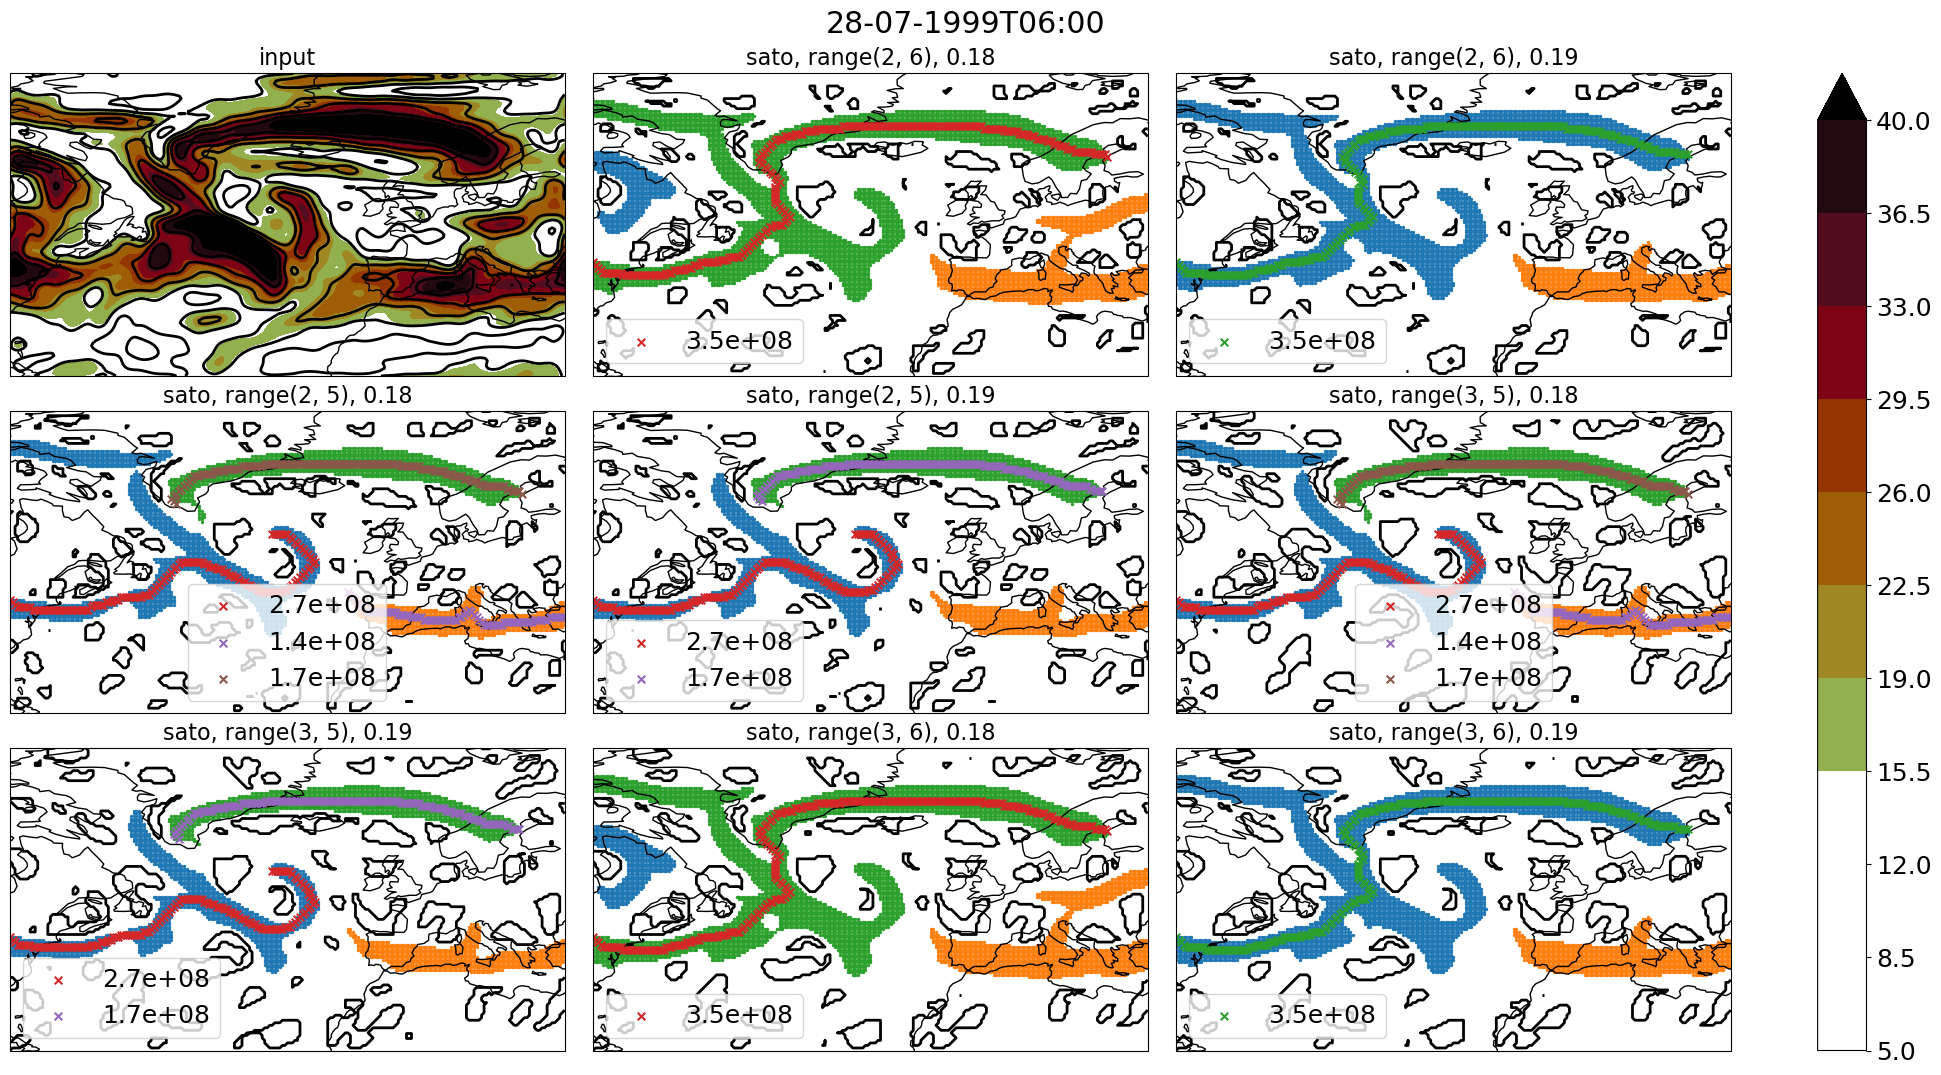

In [41]:
from skimage.filters import meijering, sato, frangi, hessian
clu = Clusterplot(3, 3, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# q = qss.loc[0.6, ds.time[it].dt.dayofyear.item()].item()
ds_ = ds.isel(time=it)
ds_ = flatten_by(ds_, "s")
with Timer():
    ds_["s_smo"] = smooth(ds_["s"], smooth_map={"lon+lat": ("fft", 0.25)})
titles = ["input"]
to_plot = [ds_["s_smo"]]
for ax, (filter_, sigmas, threshold) in tqdm(zip(clu.axes.ravel()[1:], product([sato], [range(2, 6), range(2, 5), range(3, 5), range(3, 6)], [0.18, 0.19])), total=8):
    fname = filter_.__name__
    black_ridges = fname == "hessian"
    multiply = fname == "sato"
    thisds = ds_.copy()
    thisds["s_smo"] = (("lat", "lon"), filter_(thisds["s_smo"] / thisds["s_smo"].max(), black_ridges=black_ridges, sigmas=sigmas) * (4 if multiply else 1))
    # thisds["s_smo"] = thisds["s"] / thisds["s"].max() * filter_(thisds["s"] / thisds["s"].max(), black_ridges=black_ridges, sigmas=sigmas, mode="constant", cval=0)
    to_plot.append(thisds["s_smo"])
    titles.append(f"{fname}, {sigmas}, {threshold:.2f}")
    groups, dist_mats = cluster_wind_speed(thisds, criterion_threshold=threshold, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=2)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = csgraph_from_masked(masked_weights)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 1.4e8)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.legend()
clu.add_contourf([to_plot[0]], transparify=3, nlevels=11, q=0.95, zorder=0)
_ = clu.add_contour(to_plot, titles=titles, zorder=1)
clu.fig.suptitle(ds.time[it].dt.strftime("%d-%m-%YT%H:00").item())

## Fine tune paths

 25%|██▌       | 1/4 [00:07<00:21,  7.30s/it]

no jet found
no jet found


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 50%|█████     | 2/4 [00:08<00:07,  3.56s/it]

no jet found
no jet found
no jet found


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

no jet found


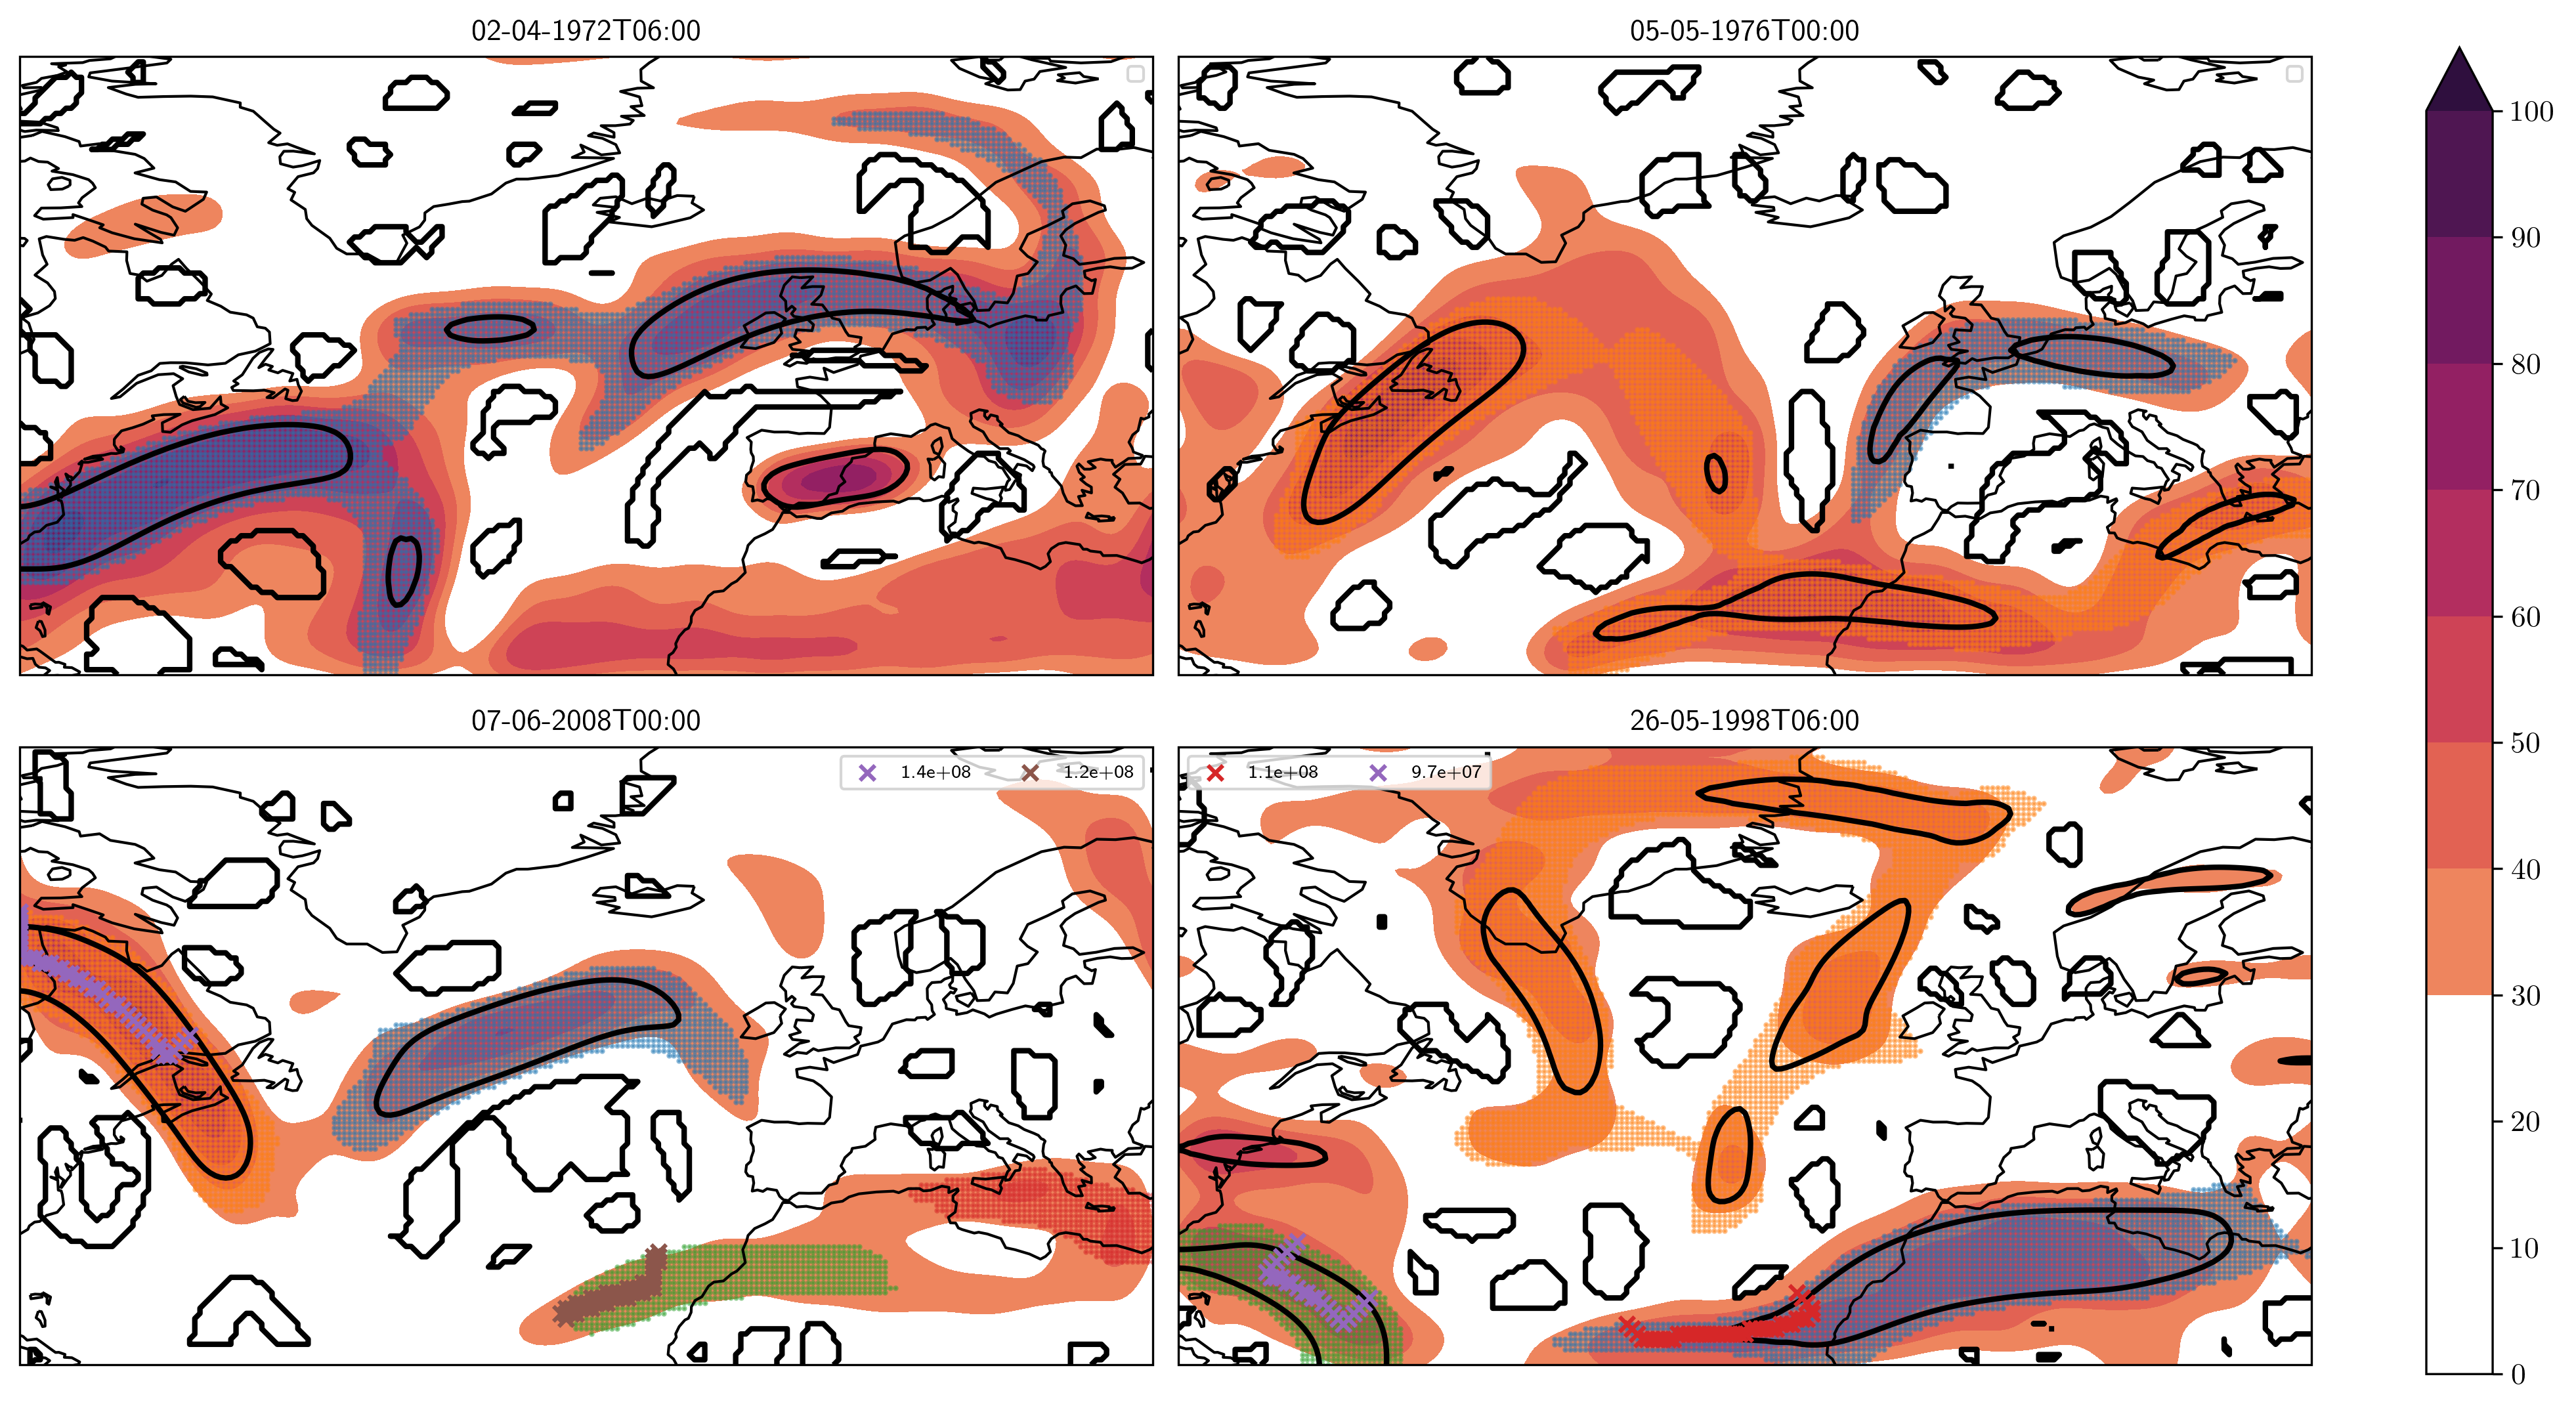

In [3]:
clu = Clusterplot(2, 2, get_region(ds))
its = np.random.randint(0, ds.time.shape[0], size=clu.nrow * clu.ncol)
norm = Normalize(.5, 4)
dss = []
for it in its:
    ds_ = ds.isel(time=it).copy()
    ds_ = preprocess(ds_)
    ds_ = compute_criterion_sato(ds_, flatten=False, sigmas=range(3, 11, 2))
    dss.append(ds_)
_ = clu.add_contourf([ds_["s_smo"] for ds_ in dss], q=0.99, cmap=colormaps.matter, transparify=3, nlevels=11)
_ = clu.add_contour([ds_["criterion"] for ds_ in dss], q=0.99, nlevels=3)
# _ = clu.add_contour([ds_["s_smo"] for ds_ in dss], nlevels=5)
for ds_, ax in tqdm(zip(dss, clu.axes.ravel()), total=len(dss)):
    groups, dist_mats = cluster_criterion(ds_, criterion_threshold=.3, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.5)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = create_graph(masked_weights, dist_mat)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 8e7)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.set_title(ds_.time.dt.strftime("%d-%m-%YT%H:00").item())
    ax.legend(ncol=2, fontsize=7)
# plt.colorbar(im, ax=clu.axes)

## Spensberger

  0%|          | 0/4 [00:00<?, ?it/s]

no jet found
no jet found
no jet found
no jet found


 25%|██▌       | 1/4 [00:01<00:04,  1.36s/it]

no jet found
no jet found


 50%|█████     | 2/4 [00:02<00:02,  1.22s/it]

no jet found
no jet found
no jet found


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 75%|███████▌  | 3/4 [00:03<00:01,  1.05s/it]

no jet found
no jet found
no jet found
no jet found
no jet found
no jet found
no jet found
no jet found
no jet found


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

no jet found


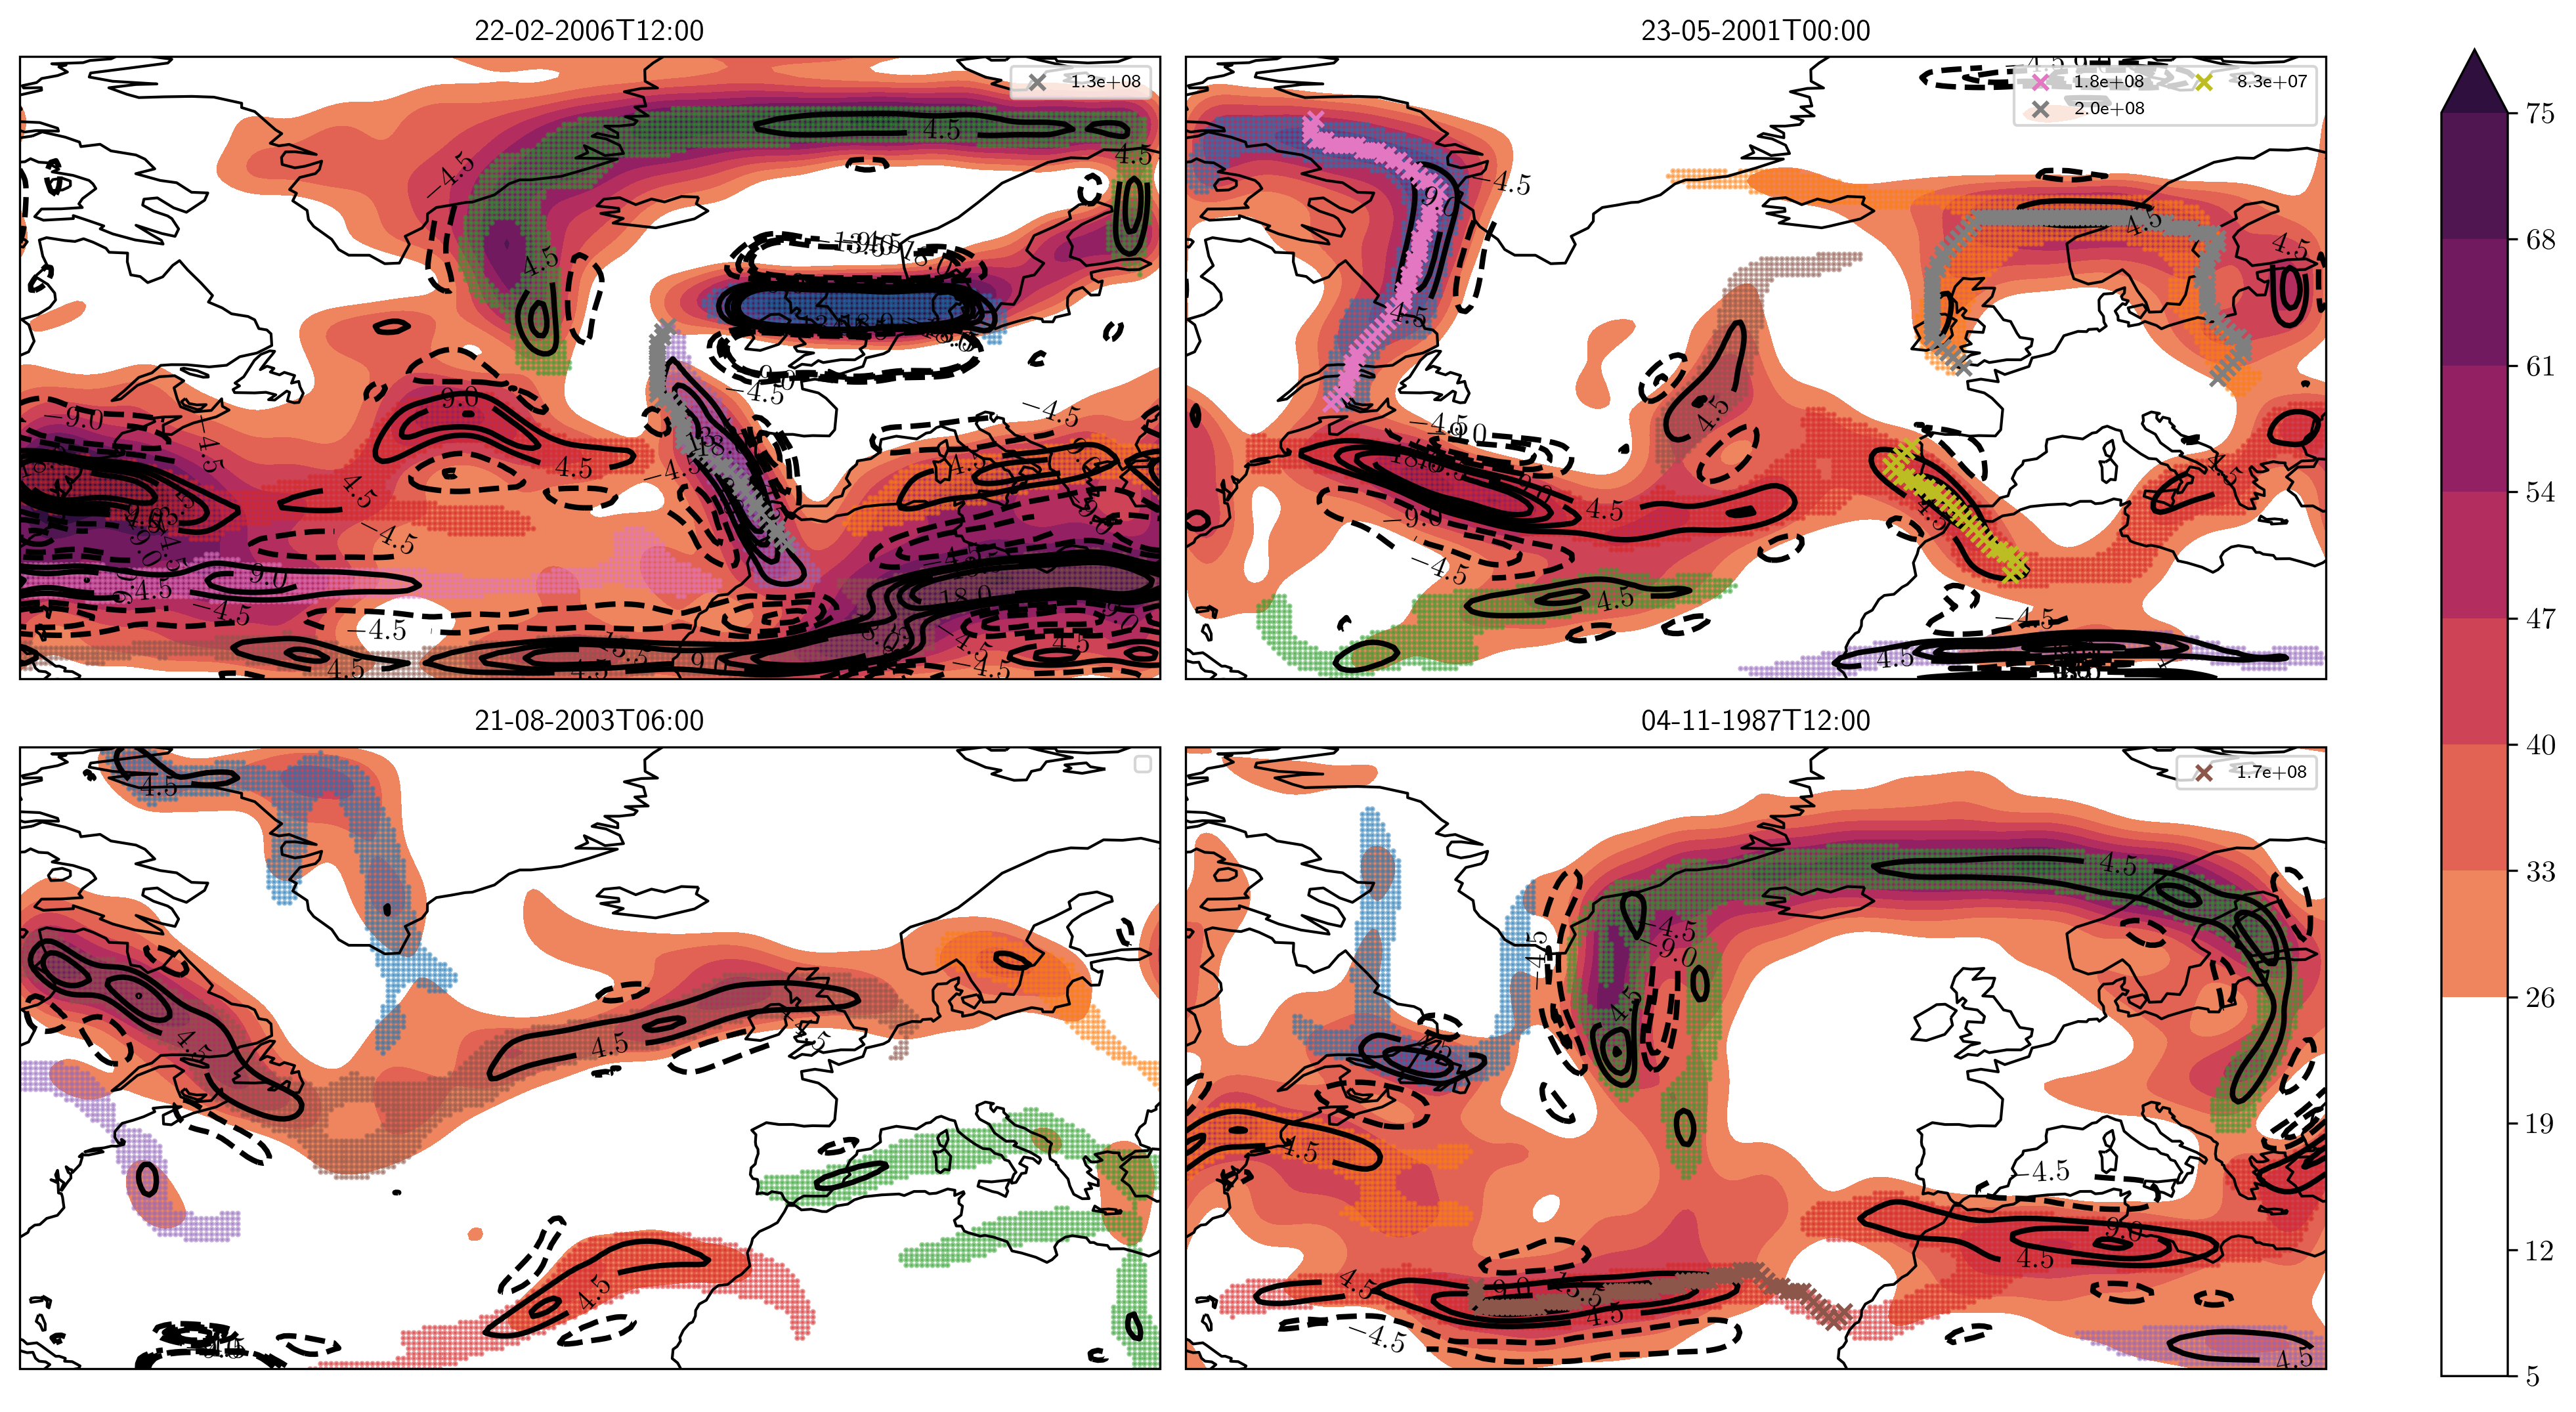

In [4]:
clu = Clusterplot(2, 2, get_region(ds))
its = np.random.randint(0, ds.time.shape[0], size=clu.nrow * clu.ncol)
norm = Normalize(.5, 4)
dss = []
for it in its:
    ds_ = ds.isel(time=it).copy()
    ds_ = preprocess(ds_, flatten_by_var="s", smooth_all=True)
    ds_ = compute_criterion_spensberger(ds_, flatten=False)
    dss.append(ds_)
_ = clu.add_contourf([ds_["s_smo"] for ds_ in dss], q=0.99, nlevels=11, cmap=colormaps.matter, transparify=3)
_ = clu.add_contour([- ds_["criterion"] * 1e9 for ds_ in dss], q=0.99, clabels=True, nlevels=5)
# _ = clu.add_contour([ds_["s_smo"] for ds_ in dss], nlevels=5)
for ds_, ax in tqdm(zip(dss, clu.axes.ravel()), total=len(dss)):
    groups, dist_mats = cluster_criterion_neg(ds_, criterion_threshold=-8e-10, distance_function=pairwise_distances, min_size=300, distance_threshold=1)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.5)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights_2(group, dist_mat)
        graph = create_graph(masked_weights, dist_mat)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 8e7)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.set_title(ds_.time.dt.strftime("%d-%m-%YT%H:00").item())
    ax.legend(ncol=2, fontsize=7)

In [134]:
ds_["criterion"] * 1e9

<xarray.DataArray 'criterion' (lat: 121, lon: 221)> Size: 214kB
array([[-0.40443, -0.31983, -0.16829, ..., -0.30932, -0.40192, -0.44361],
       [-0.69378, -0.60102, -0.44254, ..., -0.61434, -0.7024 , -0.73545],
       [-1.67314, -1.51471, -1.29269, ..., -1.76431, -1.79937, -1.76973],
       ...,
       [ 0.18218,  0.18913,  0.2128 , ...,  0.19913,  0.1964 ,  0.18507],
       [ 0.10692,  0.11892,  0.1523 , ...,  0.12133,  0.11703,  0.10575],
       [ 0.05536,  0.06877,  0.10628, ...,  0.06758,  0.06409,  0.05345]])
Coordinates:
    time     datetime64[ns] 8B 2007-01-25T06:00:00
  * lon      (lon) float32 884B -80.0 -79.5 -79.0 -78.5 ... 28.5 29.0 29.5 30.0
  * lat      (lat) float32 484B 20.0 20.5 21.0 21.5 22.0 ... 78.5 79.0 79.5 80.0

# v1000

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


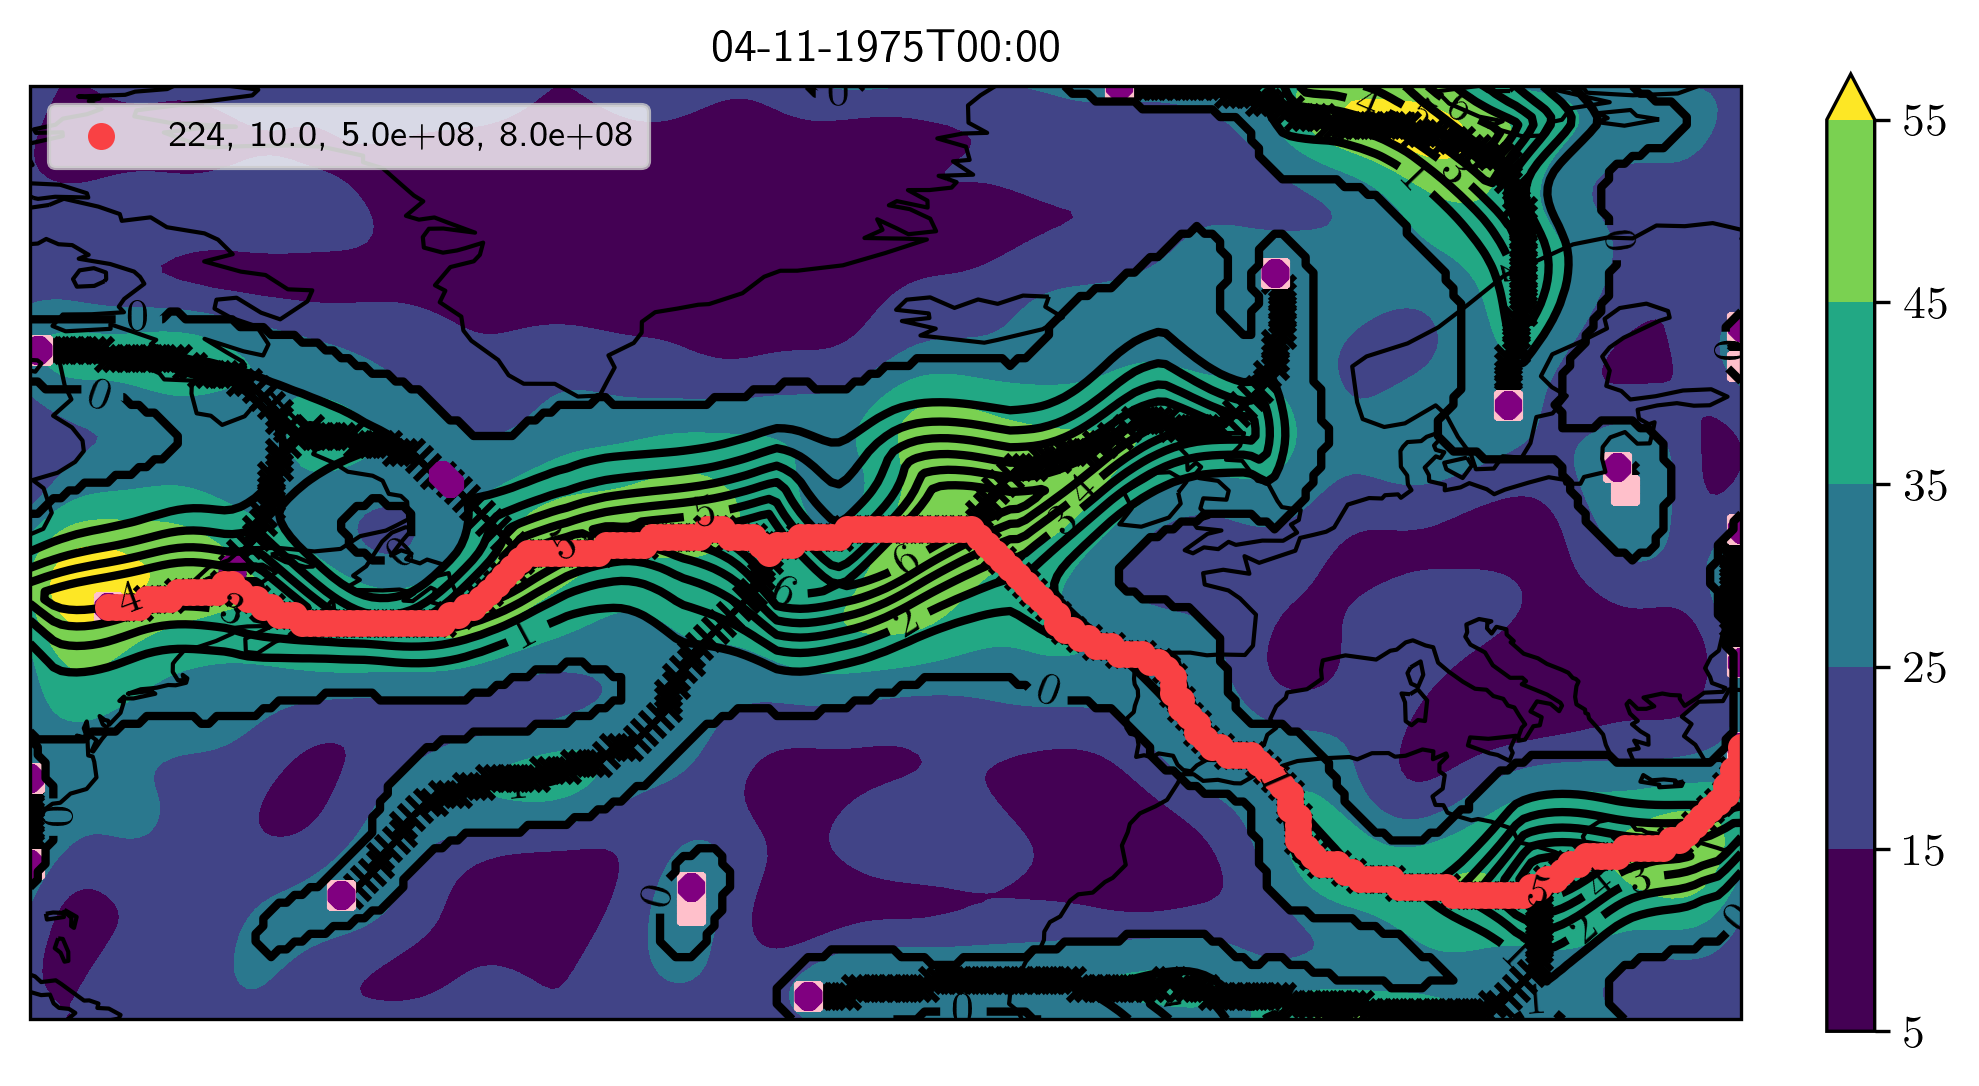

In [39]:
from scipy.ndimage import generate_binary_structure
from skimage.filters import threshold_otsu
from gwdt import gwdt


def compute_gwdt(ds: xr.Dataset):
    crit, _, _ = to_zero_one(ds["s_smo"].values)
    thresh = threshold_otsu(crit)
    fgnd_crit = crit - thresh
    fgnd_crit[fgnd_crit < 0] = 0
    structure = generate_binary_structure(crit.ndim, 1)
    ds["criterion"] = ds["s_smo"].copy(data=gwdt(fgnd_crit, structure))
    return ds


MARKERS = ["o", "v", "^", "<", ">", "2", "H", "x", "+", "d"]
clu = Clusterplot(1, 1, get_region(ds))
min_size = 50
jet_cutoff = 5e7
ratio_cutoff = 4
overlap_cutoff = .4
this_w_cutoff = 100
criterion_threshold = 0.2
edges = -80, 30
from skimage.morphology import skeletonize
its = np.random.randint(0, ds.time.shape[0], size=clu.nrow * clu.ncol)
its_ = its
norm = Normalize(.5, 4)
dss = []
for it in its_:
    ds_ = ds.isel(time=it).copy()
    ds_ = preprocess(ds_, flatten_by_var="s")
    ds_ = compute_gwdt(ds_)
    # ds_ = compute_criterion_sato(ds_, sigmas=range(4, 8), mode="nearest")
    dss.append(ds_)
_ = clu.add_contourf([ds_["s_smo"] for ds_ in dss], cmap="viridis")
_ = clu.add_contour([ds_["criterion"] for ds_ in dss], clabels=True)
for ds_, ax in tqdm(zip(dss, clu.axes.ravel()), total=len(dss)):
    lon, lat = ds.lon.values, ds.lat.values
    mask = ds_["criterion"] > 0.1
    skel = skeletonize(mask.values, method="lee")
    y, x = np.where(skel)
    x, y = lon[x], lat[y]
    sorted_order = np.argsort(x)
    x, y = x[sorted_order], y[sorted_order]
    group_ = pd.DataFrame(np.asarray([x, y]).T, columns=["lon", "lat"])
    ds_masked = slice_from_df(ds_, group_)
    group = ds_masked[["lon", "lat", "lev", "s", "u", "v", "criterion"]].reset_coords("time", drop=True).to_dataframe()
    lon, lat, s = group[["lon", "lat", "s"]].to_numpy().T
    N = len(group)
    all_nodes = np.arange(N)
    distances = my_pairwise(group_.to_numpy())
    weights = compute_weights_2(group, distances)
    graph = csgraph_from_masked(weights)
    
    starts = np.where(np.diff(graph.indptr) == 1)[0]
        
    lengths_weighted, predecessors = shortest_path(graph, indices=starts, return_predecessors=True, directed=True)
    ends = []
    for i, start in enumerate(starts):
        attainable = np.where(np.isfinite(lengths_weighted[i]) & (lengths_weighted[i] > 0))[0]
        ends.append(np.setdiff1d(attainable, predecessors[i]))

    lengths_unweighted = shortest_path(graph, indices=starts, return_predecessors=False, directed=True, unweighted=True)
    
    ax.scatter(*group[["lon", "lat"]].to_numpy().T, marker="x", color="black")
    ax.scatter(*group[["lon", "lat"]].to_numpy()[starts, :].T, marker="s", color="pink")
    ax.scatter(*group[["lon", "lat"]].to_numpy()[np.concatenate(ends), :].T, marker="8", color="purple")
    
    # potential jets: all combinations of starts and end whose path is long enough
    potentials = []
    jet_metrics = []
    for i, start in enumerate(starts):
        for j, end in enumerate(ends[i]):
            path = path_from_predecessors(predecessors[i].copy(), end)
            jet = group.iloc[path]
            jet_int = jet_integral_haversine(jet[["lon", "lat", "s"]].to_numpy())
            this_uw = lengths_unweighted[i, end]
            this_w = lengths_weighted[i, end]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ratio1 = this_uw / this_w
                ratio2 = this_uw ** 4 / this_w ** 0.5
            if jet_int > jet_cutoff and ratio1 > ratio_cutoff and this_w < this_w_cutoff:
                potentials.append((path, jet, start, end))
                jet_metrics.append({
                    "jet_int": jet_int, 
                    "uw": this_uw, 
                    "w": this_w, 
                    "ratio1": ratio1, 
                    "ratio2": ratio2, 
                })

    if len(potentials) > 1:
        total_losses = []
        for njets in range(1, 4):
            for stuff in combinations(enumerate(potentials), njets):
                loss = 0
                starts_ = []
                ends_ = []
                ks = [k for k, _ in stuff]
                covered = []
                for k, potential in stuff:
                    path, jet, start, end = potential
                    covered.extend(path)
                    loss += 10 * jet_metrics[k]["w"]
                    difflat_loss = np.abs(lat[start] - lat[end])
                    loss += 10 * difflat_loss
                    starts_.append(start)
                    ends_.append(end)
                uncovered = np.setdiff1d(all_nodes, covered, assume_unique=False)
                uncovered = group["s"].iloc[uncovered].sum()
                loss += 0.08 * uncovered
                if njets == 1:
                    total_losses.append((ks, loss))
                    continue
                for k1, k2 in combinations(ks, 2):
                    path1 = potentials[k1][0]
                    path2 = potentials[k2][0]
                    overlap = np.sum(np.isin(path1, path2))
                    loss += 5 * overlap
                total_losses.append((ks, loss))
        here = np.argmin([total_loss for _, total_loss in total_losses])
        jets = [potentials[k][1] for k in total_losses[here][0]]
        jet_metrics = [jet_metrics[k] for k in total_losses[here][0]]
    else:
        jets = [potential[1] for potential in potentials]
        
    for j, jet in enumerate(jets):
        marker = np.random.choice(MARKERS)
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker=marker, color=COLORS10[(2 * j)%10], s=30, label=f'{int(jet_metrics[j]["uw"]):d}, {jet_metrics[j]["w"]:.1f}, {jet_metrics[j]["jet_int"]:.1e}, {jet_metrics[j]["ratio2"]:.1e}', zorder=2)
    ax.set_title(ds_.time.dt.strftime("%d-%m-%YT%H:00").item())
    ax.legend(ncol=2, fontsize=9)

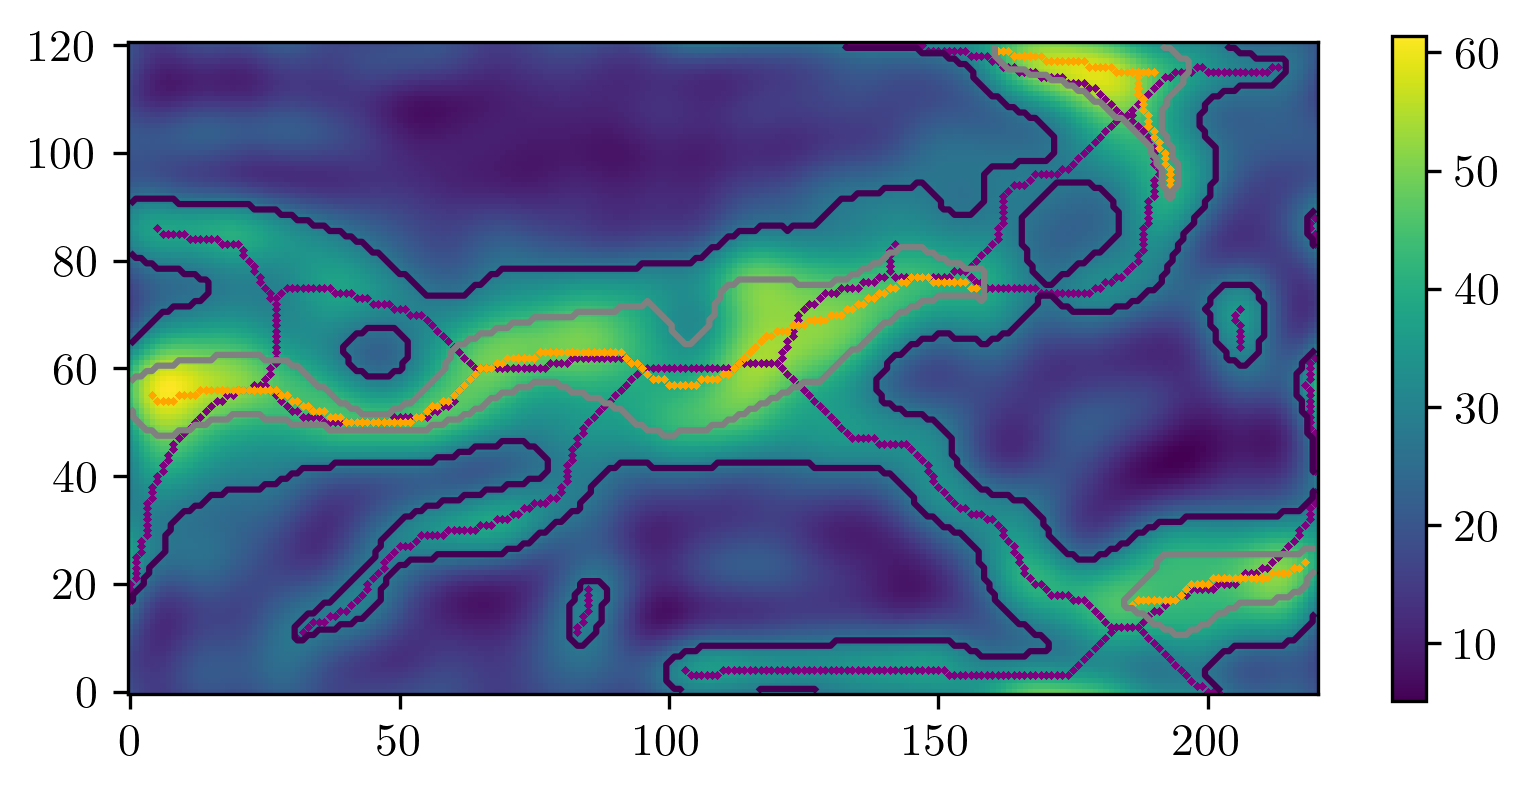

In [65]:
crit, _, _ = to_zero_one(ds_["s_smo"].values)
thresh = threshold_otsu(crit)
fgnd_crit = crit - thresh
fgnd_crit[fgnd_crit < 0] = 0
structure = generate_binary_structure(crit.ndim, 1.1 * np.sqrt(2))
# ds_["criterion"] = ds_["s_smo"].copy(data=gwdt(fgnd_crit, structure))
ds_["criterion"] = gwdt(fgnd_crit, structure) * ds_["s_smo"]

thresh = threshold_otsu(ds_["s_smo"].values)
im = plt.imshow(ds_["s_smo"], origin="lower")
mask = ds_["s_smo"] > thresh
skel = skeletonize(mask.values)
y, x = np.where(skel)
plt.contour(mask)
plt.scatter(x, y, marker="x", color="purple", s=1)

thresh = threshold_otsu(ds_["criterion"].values)
mask = ds_["criterion"] > thresh
skel = skeletonize(mask.values)
y, x = np.where(skel)
plt.contour(mask, colors="grey")
plt.scatter(x, y, marker="x", color="orange", s=1)

plt.colorbar(im, shrink=0.6)

In [50]:
np.where(skel)

(array([  0,   0,   0,   0,   0,   0,   1,   1,   1,   2,   2,   2,   2,
          2,  16,  17,  17,  17,  17,  17,  17,  17,  17,  17,  18,  19,
         19,  20,  20,  20,  20,  20,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  22,  22,  22,  23,  23,  24,  25,  50,  50,  50,
         50,  50,  50,  50,  50,  50,  50,  50,  50,  51,  51,  51,  51,
         51,  51,  52,  52,  52,  52,  53,  53,  53,  53,  53,  54,  54,
         54,  54,  54,  54,  54,  55,  55,  55,  55,  55,  55,  55,  55,
         55,  55,  55,  55,  55,  56,  56,  56,  56,  56,  56,  56,  56,
         56,  56,  56,  56,  56,  56,  57,  58,  59,  60,  60,  60,  60,
         60,  60,  60,  60,  60,  60,  60,  60,  61,  61,  61,  61,  61,
         61,  61,  61,  61,  61,  61,  61,  62,  62,  62,  62,  62,  62,
         62,  62,  62,  62,  62,  62,  62,  62,  63,  63,  63,  63,  63,
         63,  63,  63,  63,  63,  63,  63,  64,  65,  65,  65,  66,  66,
         67,  67,  67,  68,  68,  68,  69,  69,  69

In [66]:
np.concatenate(ends)

array([  0,  86, 165, 480,  86, 165, 359, 480, 473])

In [64]:
starts = np.where(np.diff(graph.indptr) == 1)[0]
lengths_weighted, predecessors = shortest_path(graph, indices=starts, return_predecessors=True, directed=True)
ends = []
for i, start in enumerate(starts):
    attainable = np.where(np.isfinite(lengths_weighted[i]))[0]
    ends.append(np.setdiff1d(attainable, predecessors[i]))

In [15]:
def alignment(group, predecessors, b):
    dx = group["lon"][b].values - group["lon"][predecessors[b]].values
    dy = group["lat"][b].values - group["lat"][predecessors[b]].values
    d = np.sqrt(dx ** 2 + dy ** 2)
    u_ =  group["u"][b].values 
    v_ =  group["v"][b].values 
    s_ =  group["s"][b].values 
    return (dx * u_ + dy * v_) / d / s_


graph, group = graphs[0], groups[0]
N = len(group)
distances, predecessors = shortest_path(graph, directed=True, unweighted=True, return_predecessors=True, indices=0)
attainable = np.where(np.isfinite(distances))[0]
ends = attainable[~np.isin(attainable, predecessors)]
print(ends, alignment(group, predecessors, ends))
distances, predecessors = shortest_path(graph, directed=False, unweighted=True, return_predecessors=True, indices=N - 1)
attainable = np.where(np.isfinite(distances))[0]
starts = attainable[~np.isin(attainable, predecessors)]
print(starts, alignment(group, predecessors, starts))

[115] [0.02566]
[  0   4   5  40 346 362] [-0.03905 -0.90817  0.40494 -0.98931  0.08713 -0.00886]


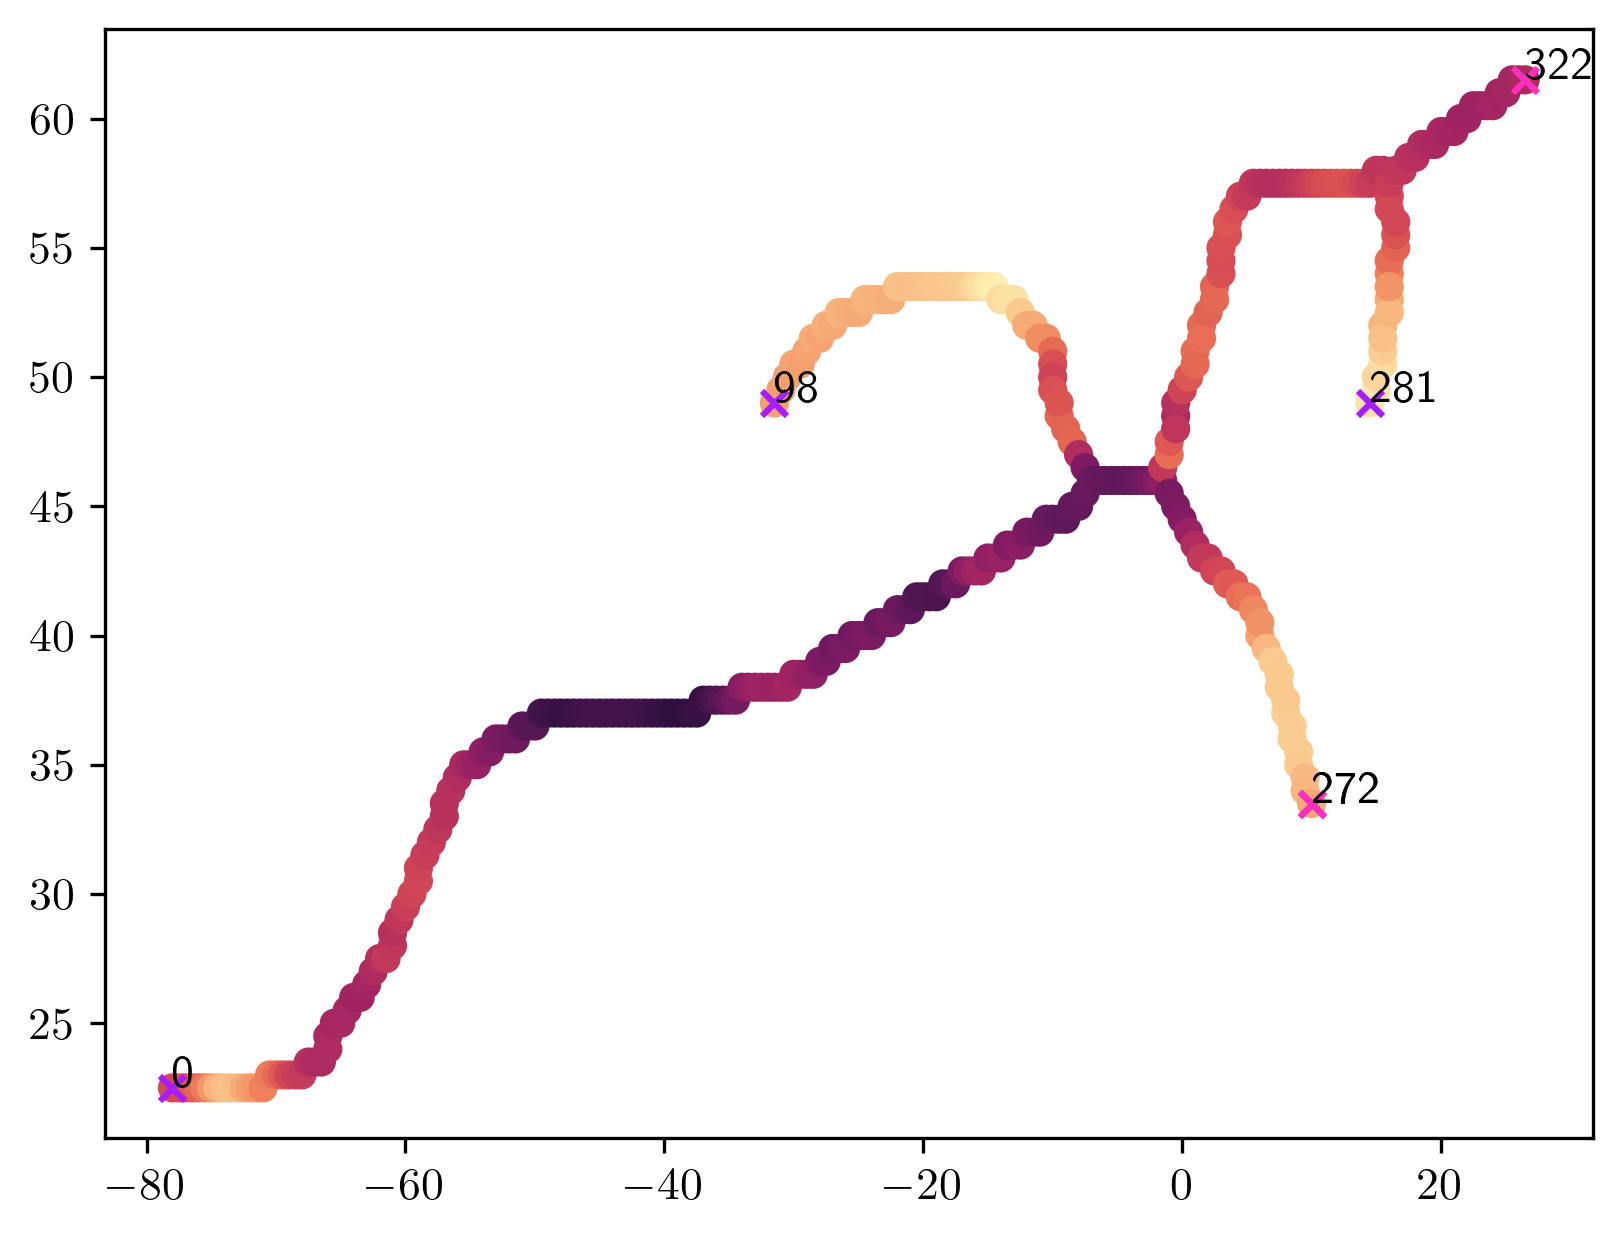

In [55]:
plt.scatter(*group[["lon", "lat"]].to_numpy().T, c=group["s"].values, cmap=colormaps.matter)
plt.scatter(*group[["lon", "lat"]].to_numpy()[starts].T, marker="x", color=COLORS[0])
for sta in starts:
    plt.text(*group[["lon", "lat"]].to_numpy()[sta].T, str(sta))
plt.scatter(*group[["lon", "lat"]].to_numpy()[ends].T, marker="x", color=COLORS[2])
for end in ends:
    plt.text(*group[["lon", "lat"]].to_numpy()[end].T, str(end))

In [36]:
(group["lat"][b].values - group["lat"][predecessors[b]].values) * group["v"][b].values / group["s"][b].values

array([ 0.49522, -0.46548])

In [26]:
predecessors[b]

array([ 1, 49, 67, 77], dtype=int32)

[2.41049 1.93686 3.75465]
[82. 71. 63.]
[2789.47281 2602.66612 1057.08992]


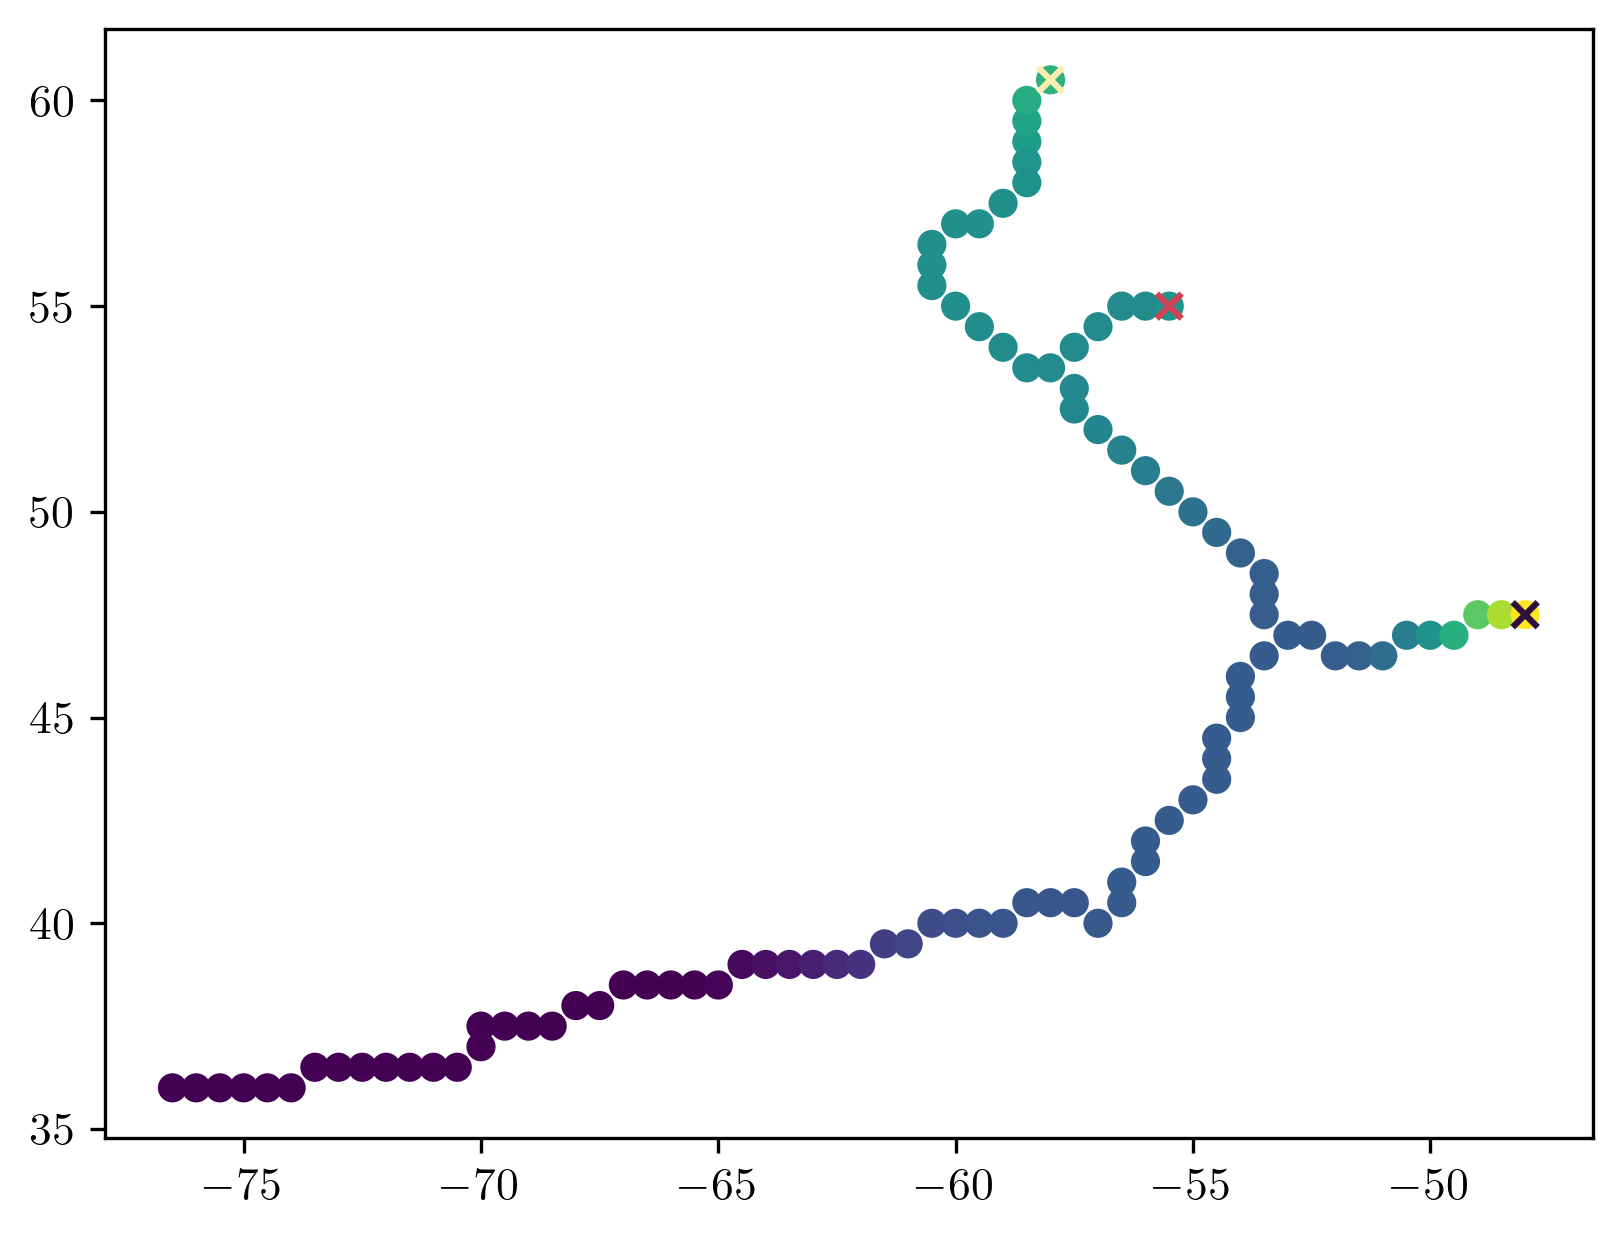

In [110]:
from scipy.sparse.csgraph import breadth_first_order, depth_first_order
group, graph = groups[0], graphs[0]
N = len(group)
lengths_weighted, predecessors = shortest_path(graph, indices=0, return_predecessors=True, directed=True)
lengths_unweighted = shortest_path(graph, indices=0, return_predecessors=False, directed=True, unweighted=True)
attainable = np.where(np.isfinite(lengths_weighted))[0]
b = attainable[~np.isin(attainable, predecessors)]
b = b[lengths_weighted[b] > 0.01]
print(lengths_weighted[b])
print(lengths_unweighted[b])
print(lengths_unweighted[b] ** 2 / lengths_weighted[b])
plt.scatter(*group[["lon", "lat"]].to_numpy().T, c=lengths_weighted)
plt.scatter(*group[["lon", "lat"]].to_numpy()[b].T, marker="x", c=np.arange(len(b)), cmap=colormaps.matter, vmin=0, vmax=2)

array([ 21, 168, 122,  81], dtype=int32)

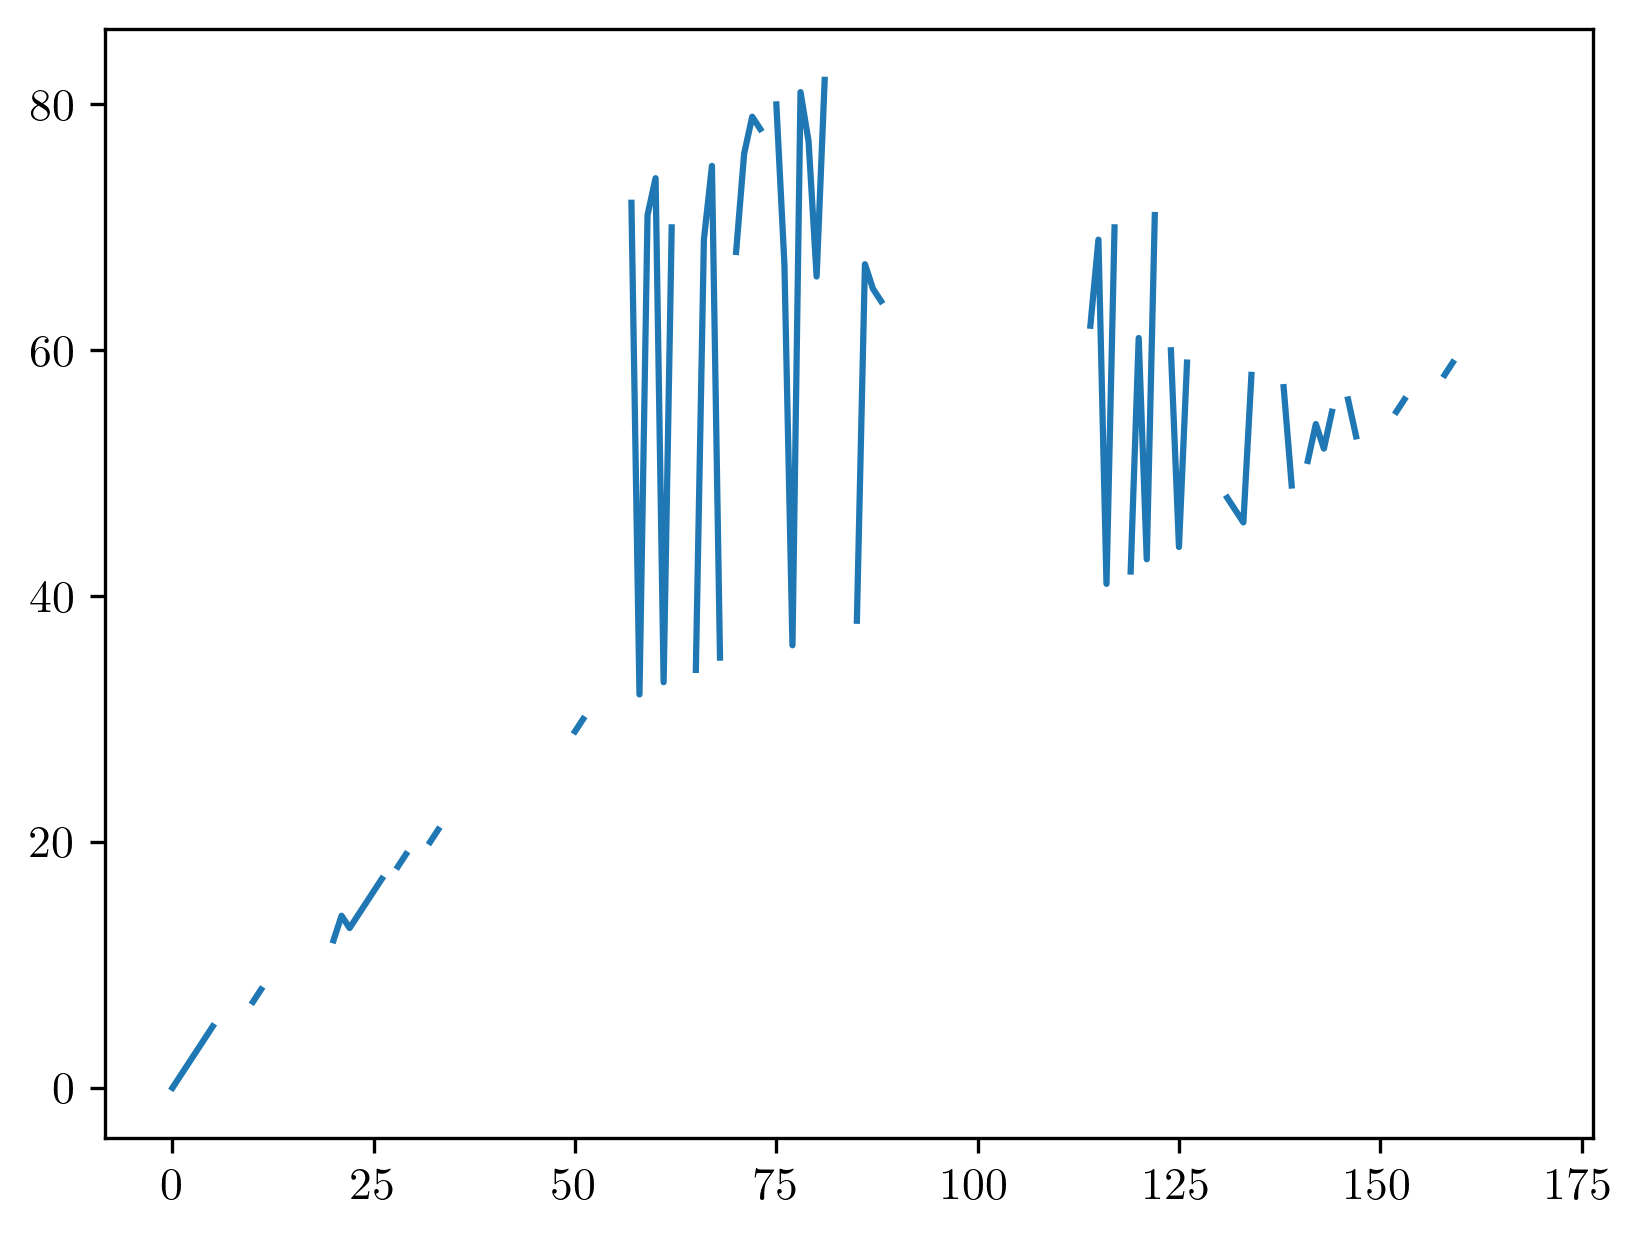

In [87]:
plt.plot()

In [179]:
imax = depth_first_order(graph, 0)[0][-1]
imin = depth_first_order(graph, imax, directed=False)[0][-1]

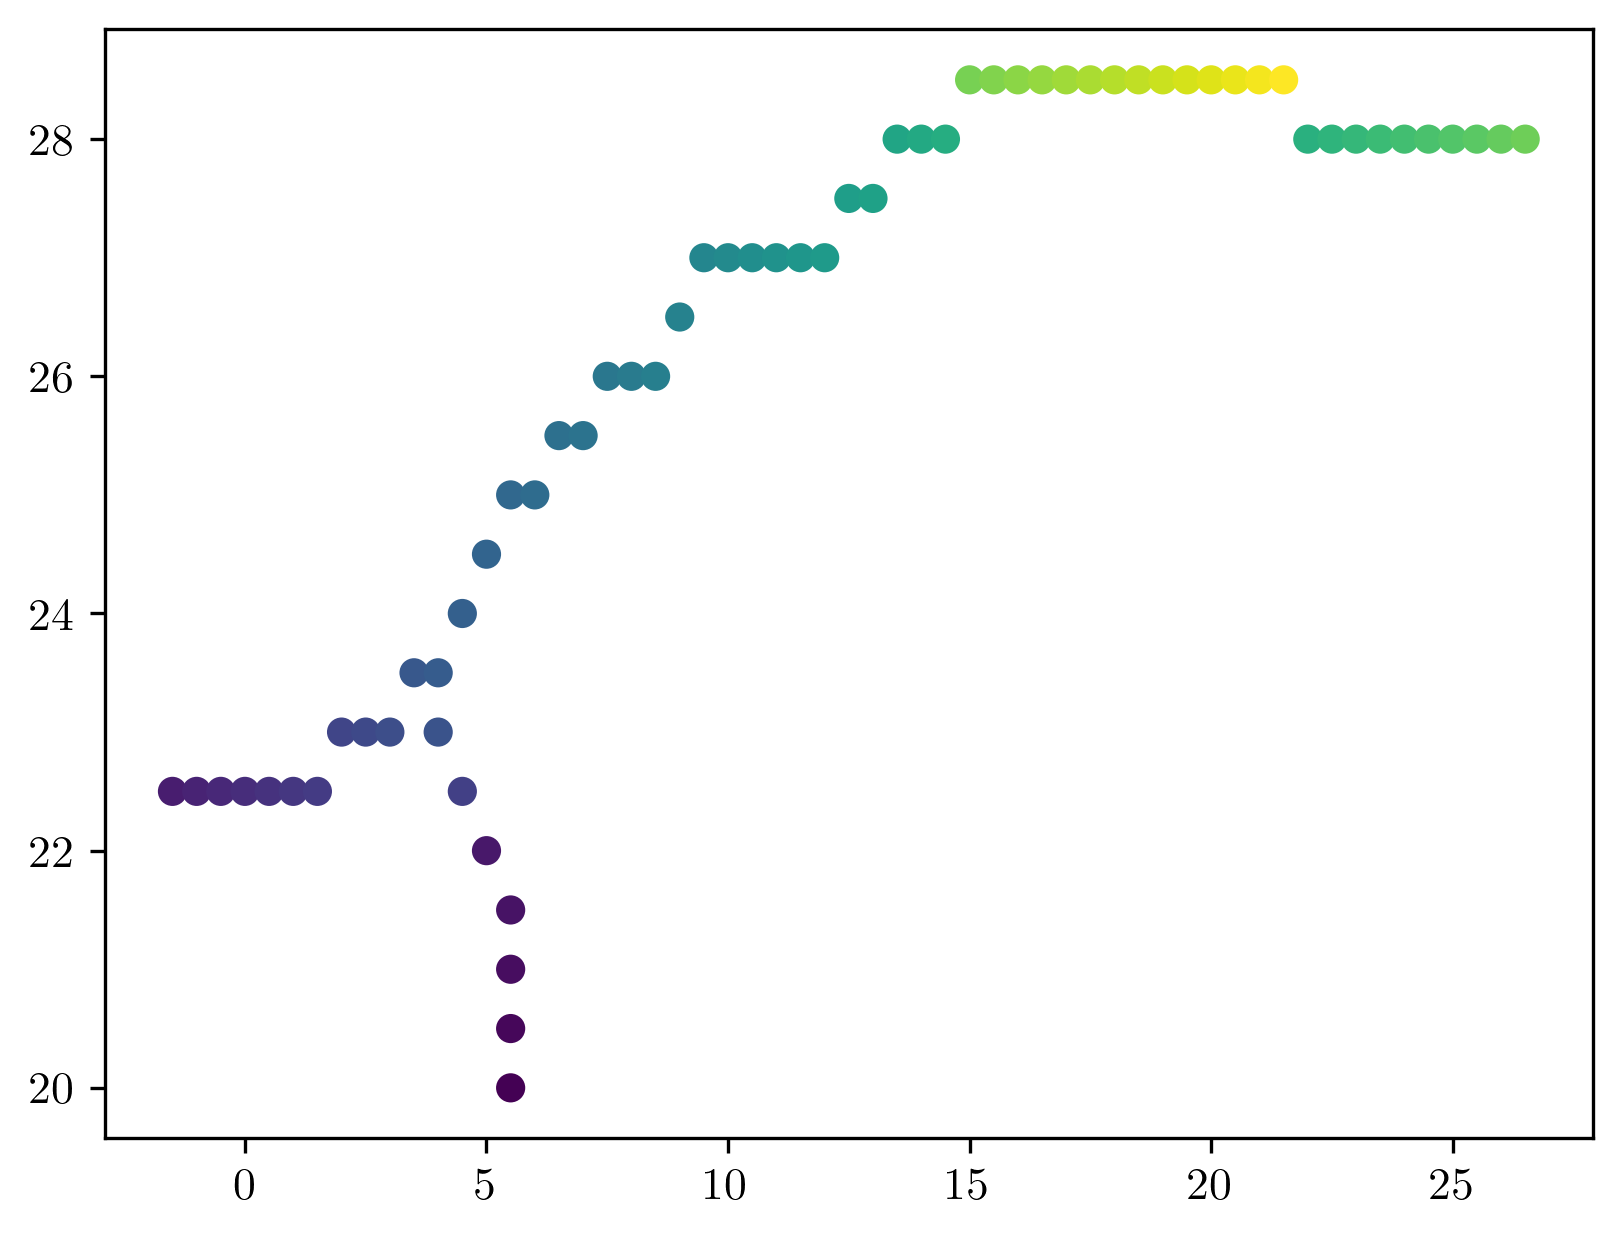

In [170]:
from scipy.sparse.csgraph import depth_first_order
graph, group = graphs[0], groups[0]
plt.scatter(*group[["lon", "lat"]].to_numpy().T, c=np.arange(64))

from this:
- turn to one graph
- compute weights
- compute is_nei also with wind direction
- cut in several using connected_components
- shortest path to get rid of the stupid branches

# Extreme climatology

In [49]:
sparse_exp = MultiVarExperiment("ERA5", "plev", ["s", "u", "v"], "6H", np.arange(1950, 2022, 5).tolist(), None, -80, 30, 20, 80, [200, 250, 300])

[########################################] | 100% Completed | 281.52 s


In [50]:
ds = sparse_exp.ds

In [51]:
ds = preprocess(ds)

100%|██████████| 18992/18992 [05:42<00:00, 55.48it/s]


In [57]:
q_clim = compute_clim(ds["s"].quantile(np.arange(0.6, 1, 0.05), ["lon", "lat"]), "dayofyear")

In [58]:
q_clim = smooth(q_clim, {"dayofyear": ("win", 60)})
q_clim.to_netcdf(f"{DATADIR}/ERA5/plev/results/s_q_clim.nc")

# Anim demo

In [8]:
def open_ds():
    ds = xr.Dataset()
    ds["u"] = open_da("ERA5", "plev", "u", "6H", 2000, [1, 2, 3, 4, 5, 6])[..., ::2, ::2].load()
    ds["v"] = open_da("ERA5", "plev", "v", "6H", 2000, [1, 2, 3, 4, 5, 6])[..., ::2, ::2].load()
    return ds

ds = open_ds()

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

In [9]:
jet_finder = JetFinder(
    preprocess=preprocess,
    cluster=cluster_criterion,
    refine_jets=jets_from_mask,
)

In [10]:
qss = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/4/qs_clim.nc")[20, :]

In [11]:
jets = jet_finder.call(ds, qss, processes=14)

100%|██████████| 728/728 [04:43<00:00,  2.57it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


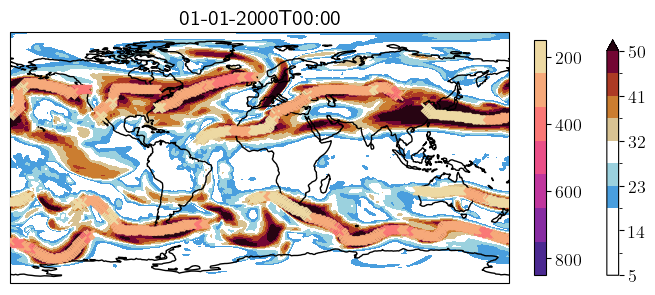

In [12]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds))
fig = clu.fig
ax = clu.axes[0]
times = ds.time
lon, lat = ds.lon.values, ds.lat.values
ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
ds_flat = flatten_by(ds, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
cmap_scatter = colormaps.agsunset_r
norm_scatter = Normalize(ds.lev.min(), ds.lev.max())
offsets = []
colors = []
for jet in jets[0]:
    offsets.append(jet[["lon", "lat"]])
    colors.append(jet["lev"])
pc = ax.scatter(*offsets[0].to_numpy().T, c=colors[0].tolist(), marker='x', norm=norm_scatter, cmap=cmap_scatter, zorder=100)
pc.set_offsets(np.concatenate(offsets))
pc.set_array(np.concatenate(colors))
cbar = fig.colorbar(cs, shrink=0.75)
cbar2 = fig.colorbar(pc, shrink=0.75)
cbar2.ax.invert_yaxis()

def animate(i):
    global pc
    global cs
    cs.remove()
    offsets = []
    colors = []
    for jet in jets[i]:
        offsets.append(jet[["lon", "lat"]])
        colors.append(jet["lev"])
    try:
        offsets = np.concatenate(offsets)
        colors = np.concatenate(colors)
    except ValueError:
        offsets = np.asarray([[0, 0]])
        colors = [0.5]
    pc.set_offsets(offsets)
    pc.set_array(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return pc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(0, len(times), 4))
ani.save("Figures/jet_anim.gif", dpi=150, fps=1)

# Anim track demo

In [ ]:
mask_202x = np.isin(DATERANGEPL_EXT_6H.year, [2020, 2021, 2022])
all_jets = load_pickle(ofile_aj)
all_jets = [all_jets[i] for i in np.where(mask_202x)[0]]
where_are_jets = np.load(ofile_waj)[mask_202x]
all_jets_one_array = np.load(ofile_ajoa)
ajot = np.load(ofile_ajot)
flags = np.load(ofile_flags)[mask_202x]

In [3]:
exp_wind = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (2020, 2022), None, -80, 30, 20, 80, [200, 250, 300])
ds = exp_wind.ds

MovieWriter ffmpeg unavailable; using Pillow instead.


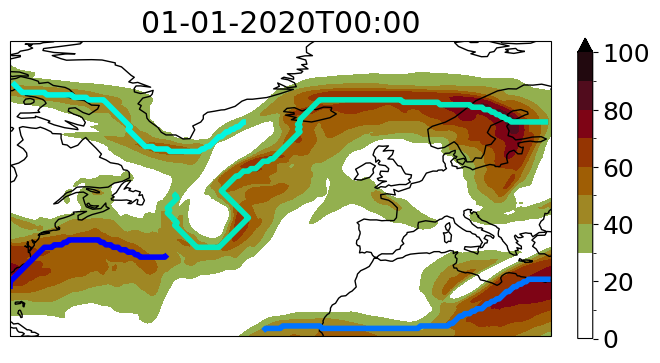

In [14]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds))
fig = clu.fig
ax = clu.axes[0]
times = ds.time
lon, lat = ds.lon.values, ds.lat.values
ds_flat = flatten_by(ds, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
minflag = flags.min()
flags -= minflag
maxflag = np.amax(flags[flags < flags.max()])
nturns = 30
flag_colors = colormaps.BlAqGrYeOrReVi200(np.linspace(0, nturns, maxflag) % 1)
segments = []
colors = []
for j, jet in enumerate(all_jets[0]):
    segments.append(jet[["lon", "lat"]].to_numpy())
    colors.append(flag_colors[flags[0, j]])
lc = LineCollection(segments, colors=colors, lw=4)
ax.add_collection(lc)
cbar = fig.colorbar(cs)

def animate(i):
    global lc
    global cs
    for c in cs.collections:
        c.remove()
    segments = []
    colors = []
    for j, jet in enumerate(all_jets[i]):
        segments.append(jet[["lon", "lat"]].to_numpy())
        colors.append(flag_colors[flags[i, j]])
    lc.set_segments(segments)
    lc.set_colors(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return lc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(0, 31 * 4))
ani.save("Figures/jet_anim_tracks.gif", dpi=150, fps=1)